# Real-Time Algorithmic Trading Bot (MA Crossover + Risk Management)

### Developed by: **Syed Zain Ahmed**


This notebook implements an **algorithmic trading system** with:
- Moving Average Crossover strategy (50-day vs 200-day).
- Strict risk management: 1% risk per trade, max 3% portfolio exposure.
- Backtesting on 2+ years of historical-like data (2023–2025).
- Performance metrics: Sharpe ratio, Max Drawdown, Win Rate, Annualized Return.


In [38]:
!pip install pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Optional
from datetime import datetime

plt.style.use("seaborn-v0_8")

print("Imports loaded successfully.")

Imports loaded successfully.


In [39]:
# ========================
# Global configuration
# ========================

@dataclass
class StrategyConfig:
    short_ma: int = 50
    long_ma: int = 200

@dataclass
class RiskConfig:
    initial_capital: float = 100_000.0
    risk_per_trade: float = 0.01        # 1% per trade
    max_portfolio_exposure: float = 0.03 # 3% of capital
    max_positions: int = 10
    max_daily_loss: float = 0.05        # 5%
    max_drawdown: float = 0.15          # 15%

@dataclass
class BacktestConfig:
    start_date: str = "2023-01-01"
    end_date: str = "2025-12-31"
    commission: float = 0.0005          # 0.05%
    slippage: float = 0.001             # 0.1%

strategy_cfg = StrategyConfig()
risk_cfg = RiskConfig()
bt_cfg = BacktestConfig()

print(strategy_cfg)
print(risk_cfg)
print(bt_cfg)

StrategyConfig(short_ma=50, long_ma=200)
RiskConfig(initial_capital=100000.0, risk_per_trade=0.01, max_portfolio_exposure=0.03, max_positions=10, max_daily_loss=0.05, max_drawdown=0.15)
BacktestConfig(start_date='2023-01-01', end_date='2025-12-31', commission=0.0005, slippage=0.001)


In [40]:
# ========================
# Technical indicators & utilities
# ========================

def sma(series: pd.Series, window: int) -> pd.Series:
    return series.rolling(window=window, min_periods=window).mean()

def ema(series: pd.Series, window: int) -> pd.Series:
    return series.ewm(span=window, adjust=False).mean()

def atr(high: pd.Series, low: pd.Series, close: pd.Series, window: int = 14) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window=window, min_periods=window).mean()

def compute_drawdown(equity: pd.Series) -> pd.Series:
    running_max = equity.cummax()
    dd = (equity - running_max) / running_max
    return dd

def sharpe_ratio(returns: pd.Series, risk_free_rate: float = 0.0, periods_per_year: int = 252) -> float:
    if returns.std() == 0 or len(returns) == 0:
        return 0.0
    excess = returns - risk_free_rate / periods_per_year
    return np.sqrt(periods_per_year) * excess.mean() / excess.std()

def annualized_return(equity: pd.Series, periods_per_year: int = 252) -> float:
    if len(equity) < 2:
        return 0.0
    total_return = equity.iloc[-1] / equity.iloc[0] - 1.0
    years = len(equity) / periods_per_year
    if years <= 0:
        return 0.0
    return (1 + total_return) ** (1 / years) - 1.0

print("Indicator utilities defined.")

Indicator utilities defined.


In [41]:
# ========================
# Trading strategy
# ========================

class MovingAverageCrossoverStrategy:
    """
    Simple MA Crossover:
    - Buy when short MA crosses above long MA.
    - Sell/short when short MA crosses below long MA (for this example we just flat).
    """
    def __init__(self, short_window: int, long_window: int):
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df["sma_short"] = sma(df["close"], self.short_window)
        df["sma_long"] = sma(df["close"], self.long_window)

        df["signal"] = 0
        # 1 when short crosses above long, -1 when below (we'll only go long-flat to keep it simple)
        long_entries = (df["sma_short"] > df["sma_long"]) & (df["sma_short"].shift(1) <= df["sma_long"].shift(1))
        long_exits   = (df["sma_short"] < df["sma_long"]) & (df["sma_short"].shift(1) >= df["sma_long"].shift(1))

        df.loc[long_entries, "signal"] = 1
        df.loc[long_exits,   "signal"] = -1  # interpret as close long

        return df

# ========================
# Risk manager (1% rule + exposure)
# ========================

class RiskManager:
    def __init__(self, config: RiskConfig):
        self.cfg = config
        self.initial_capital = config.initial_capital
        self.cash = config.initial_capital
        self.positions: Dict[str, Dict] = {}
        self.equity_curve: List[float] = []
        self.max_equity = self.initial_capital
        self.daily_pnl = 0.0

    def position_size(self, price: float, stop_loss: float) -> int:
        risk_amount = self.cash * self.cfg.risk_per_trade
        risk_per_unit = abs(price - stop_loss)
        if risk_per_unit == 0:
            return 0
        qty = int(risk_amount / risk_per_unit)
        # Cap by max exposure
        max_notional = self.cash * self.cfg.max_portfolio_exposure
        max_qty = int(max_notional / price)
        qty = max(0, min(qty, max_qty))
        return qty

    def update_equity(self, total_value: float):
        self.equity_curve.append(total_value)
        if total_value > self.max_equity:
            self.max_equity = total_value

    def check_drawdown_limit(self) -> bool:
        if not self.equity_curve:
            return True
        current_equity = self.equity_curve[-1]
        dd = (self.max_equity - current_equity) / self.max_equity
        return dd <= self.cfg.max_drawdown

# ========================
# Backtester
# ========================

class Backtester:
    def __init__(self,
                 data: pd.DataFrame,
                 strategy: MovingAverageCrossoverStrategy,
                 risk_manager: RiskManager,
                 bt_config: BacktestConfig,
                 ticker: str = "INFY"):
        self.data = data.copy().reset_index(drop=True)
        self.strategy = strategy
        self.rm = risk_manager
        self.bt_cfg = bt_config
        self.ticker = ticker
        self.trades: List[Dict] = []

    def run(self):
        df = self.strategy.generate_signals(self.data)
        df["position"] = 0  # 1 for long, 0 for flat
        current_position = 0
        entry_price = None
        qty = 0

        # Pre-compute ATR for SL placement
        df["atr"] = atr(df["high"], df["low"], df["close"], window=14)

        equity = self.rm.initial_capital
        self.rm.update_equity(equity)

        for i, row in df.iterrows():
            price = row["close"]
            signal = row["signal"]

            # Close position if signal = -1 (MA cross down)
            if signal == -1 and current_position == 1:
                # Exit at current price
                exit_price = price
                gross_pnl = (exit_price - entry_price) * qty
                commission = abs(exit_price * qty) * self.bt_cfg.commission
                slippage = abs(exit_price * qty) * self.bt_cfg.slippage
                net_pnl = gross_pnl - commission - slippage
                self.rm.cash += net_pnl
                current_position = 0

                self.trades.append({
                    "side": "LONG",
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "qty": qty,
                    "pnl": net_pnl
                })

            # Open position if signal = 1 and we are flat
            if signal == 1 and current_position == 0:
                # Define stop-loss using ATR; if ATR is NaN, use 2% of price
                this_atr = row["atr"]
                if np.isnan(this_atr) or this_atr <= 0:
                    stop_loss = price * 0.98
                else:
                    stop_loss = price - 2 * this_atr

                qty = self.rm.position_size(price, stop_loss)
                if qty > 0:
                    commission = abs(price * qty) * self.bt_cfg.commission
                    slippage = abs(price * qty) * self.bt_cfg.slippage
                    cost = price * qty + commission + slippage
                    if cost <= self.rm.cash:
                        self.rm.cash -= cost
                        entry_price = price
                        current_position = 1
                    else:
                        qty = 0  # skip if not enough cash

            # Mark-to-market equity
            position_value = qty * price if current_position == 1 else 0
            equity = self.rm.cash + position_value
            self.rm.update_equity(equity)

            if not self.rm.check_drawdown_limit():
                print(f"Max drawdown limit reached at index {i}, stopping backtest.")
                break

        equity_series = pd.Series(self.rm.equity_curve, index=df.index[:len(self.rm.equity_curve)])
        return equity_series, pd.DataFrame(self.trades)

    def performance_report(self, equity: pd.Series, trades: pd.DataFrame) -> Dict:
        daily_ret = equity.pct_change().dropna()
        sharpe = sharpe_ratio(daily_ret)
        ann_ret = annualized_return(equity)
        dd = compute_drawdown(equity)
        max_dd = dd.min()

        total_trades = len(trades)
        wins = (trades["pnl"] > 0).sum() if total_trades > 0 else 0
        losses = (trades["pnl"] <= 0).sum() if total_trades > 0 else 0
        win_rate = wins / total_trades * 100 if total_trades > 0 else 0.0

        report = {
            "total_trades": int(total_trades),
            "winning_trades": int(wins),
            "losing_trades": int(losses),
            "win_rate": win_rate,
            "sharpe_ratio": sharpe,
            "max_drawdown_pct": float(max_dd * 100),
            "annualized_return_pct": float(ann_ret * 100),
            "final_equity": float(equity.iloc[-1]),
            "initial_capital": float(self.rm.initial_capital)
        }
        return report

print("Strategy, RiskManager, Backtester defined.")

Strategy, RiskManager, Backtester defined.


In [42]:
# ========================
# Synthetic OHLCV generator
# ========================

def generate_synthetic_ohlcv(start_date: str, end_date: str, seed: int = 42) -> pd.DataFrame:
    """
    Generate synthetic OHLCV data that roughly mimics an equity timeseries.
    This ensures the notebook runs anywhere without external APIs.
    """
    np.random.seed(seed)
    dates = pd.date_range(start=start_date, end=end_date, freq="B")  # business days
    n = len(dates)

    # Simulate log-returns with slight positive drift
    mu = 0.0004    # daily drift ~10% annualized
    sigma = 0.01   # daily volatility
    log_rets = np.random.normal(mu, sigma, size=n)
    price = 100 * np.exp(log_rets.cumsum())

    # Generate OHLCV around the close
    close = price
    open_ = close * (1 + np.random.normal(0, 0.002, size=n))
    high = np.maximum(open_, close) * (1 + np.abs(np.random.normal(0, 0.003, size=n)))
    low = np.minimum(open_, close) * (1 - np.abs(np.random.normal(0, 0.003, size=n)))
    volume = np.random.randint(100_000, 1_000_000, size=n)

    df = pd.DataFrame({
        "timestamp": dates,
        "open": open_,
        "high": high,
        "low": low,
        "close": close,
        "volume": volume
    })
    df.set_index("timestamp", inplace=True)
    return df

data = generate_synthetic_ohlcv(bt_cfg.start_date, bt_cfg.end_date)
data.head()

,open,high,low,close,volume
timestamp,,,,,
2023-01-02,100.660931,100.681161,100.419920,100.538157,525659
2023-01-03,100.551862,100.707498,100.120034,100.439412,327203
2023-01-04,101.351107,101.826205,100.945305,101.132503,819846
2023-01-05,102.896983,103.060297,102.514992,102.725653,761237
2023-01-06,102.620557,102.865081,102.106261,102.526401,139553


In [43]:
# ========================
# Corrected Backtester (fixes equity / index length mismatch)
# ========================

class Backtester:
    def __init__(self,
                 data: pd.DataFrame,
                 strategy: MovingAverageCrossoverStrategy,
                 risk_manager: RiskManager,
                 bt_config: BacktestConfig,
                 ticker: str = "INFY"):
        # Keep original index (datetime) so we can align equity series to timestamps.
        # Do not reset_index(drop=True) here.
        self.data = data.copy()
        self.strategy = strategy
        self.rm = risk_manager
        self.bt_cfg = bt_config
        self.ticker = ticker
        self.trades: List[Dict] = []

    def run(self):
        df = self.strategy.generate_signals(self.data)
        df = df.copy()  # ensure we have a local copy
        df["position"] = 0  # 1 for long, 0 for flat
        current_position = 0
        entry_price = None
        qty = 0

        # Pre-compute ATR for SL placement
        df["atr"] = atr(df["high"], df["low"], df["close"], window=14)

        # Start equity with initial capital (this will be the first entry in equity_curve)
        equity = self.rm.initial_capital
        self.rm.update_equity(equity)

        for i, row in df.iterrows():
            price = row["close"]
            signal = row["signal"]

            # Close position if signal = -1 (MA cross down)
            if signal == -1 and current_position == 1:
                # Exit at current price
                exit_price = price
                gross_pnl = (exit_price - entry_price) * qty
                commission = abs(exit_price * qty) * self.bt_cfg.commission
                slippage = abs(exit_price * qty) * self.bt_cfg.slippage
                net_pnl = gross_pnl - commission - slippage
                self.rm.cash += net_pnl
                current_position = 0

                self.trades.append({
                    "side": "LONG",
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "qty": qty,
                    "pnl": net_pnl
                })
                # reset qty and entry
                qty = 0
                entry_price = None

            # Open position if signal = 1 and we are flat
            if signal == 1 and current_position == 0:
                # Define stop-loss using ATR; if ATR is NaN, use 2% of price
                this_atr = row["atr"]
                if pd.isna(this_atr) or this_atr <= 0:
                    stop_loss = price * 0.98
                else:
                    stop_loss = price - 2 * this_atr

                qty = self.rm.position_size(price, stop_loss)
                if qty > 0:
                    commission = abs(price * qty) * self.bt_cfg.commission
                    slippage = abs(price * qty) * self.bt_cfg.slippage
                    cost = price * qty + commission + slippage
                    if cost <= self.rm.cash:
                        self.rm.cash -= cost
                        entry_price = price
                        current_position = 1
                    else:
                        qty = 0  # skip if not enough cash

            # Mark-to-market equity
            position_value = qty * price if current_position == 1 else 0
            equity = self.rm.cash + position_value
            self.rm.update_equity(equity)

            if not self.rm.check_drawdown_limit():
                print(f"Max drawdown limit reached at index {i}, stopping backtest.")
                break

        # Build equity series with an index aligned to timestamps.
        # equity_curve length is initial point + one per iteration (len = n + 1).
        eq_values = self.rm.equity_curve

        # Try to construct a datetime index that is one step earlier for the initial capital.
        try:
            # df.index is expected to be a DatetimeIndex (business-day series from generator)
            first_ts = df.index[0]
            # choose previous business day as the synthetic timestamp for initial equity
            # if index is datetime-like, we subtract one calendar day; for robust alignment it is acceptable here
            initial_ts = first_ts - pd.Timedelta(days=1)
            equity_index = df.index.insert(0, initial_ts)
            # If lengths still mismatch for any reason, fall back to a simple RangeIndex below.
            if len(equity_index) != len(eq_values):
                raise ValueError("index length mismatch after insert")
            equity_series = pd.Series(eq_values, index=equity_index)
        except Exception:
            # Fallback: just use a simple RangeIndex (guaranteed to match lengths)
            equity_series = pd.Series(eq_values, index=pd.RangeIndex(start=0, stop=len(eq_values)))

        return equity_series, pd.DataFrame(self.trades)

    def performance_report(self, equity: pd.Series, trades: pd.DataFrame) -> Dict:
        daily_ret = equity.pct_change().dropna()
        sharpe = sharpe_ratio(daily_ret)
        ann_ret = annualized_return(equity)
        dd = compute_drawdown(equity)
        max_dd = dd.min() if not dd.empty else 0.0

        total_trades = len(trades)
        wins = (trades["pnl"] > 0).sum() if total_trades > 0 else 0
        losses = (trades["pnl"] <= 0).sum() if total_trades > 0 else 0
        win_rate = wins / total_trades * 100 if total_trades > 0 else 0.0

        report = {
            "total_trades": int(total_trades),
            "winning_trades": int(wins),
            "losing_trades": int(losses),
            "win_rate": win_rate,
            "sharpe_ratio": sharpe,
            "max_drawdown_pct": float(max_dd * 100),
            "annualized_return_pct": float(ann_ret * 100),
            "final_equity": float(equity.iloc[-1]) if len(equity) > 0 else float(self.rm.initial_capital),
            "initial_capital": float(self.rm.initial_capital)
        }
        return report


Found existing equity and trades variables. Proceeding to plot.


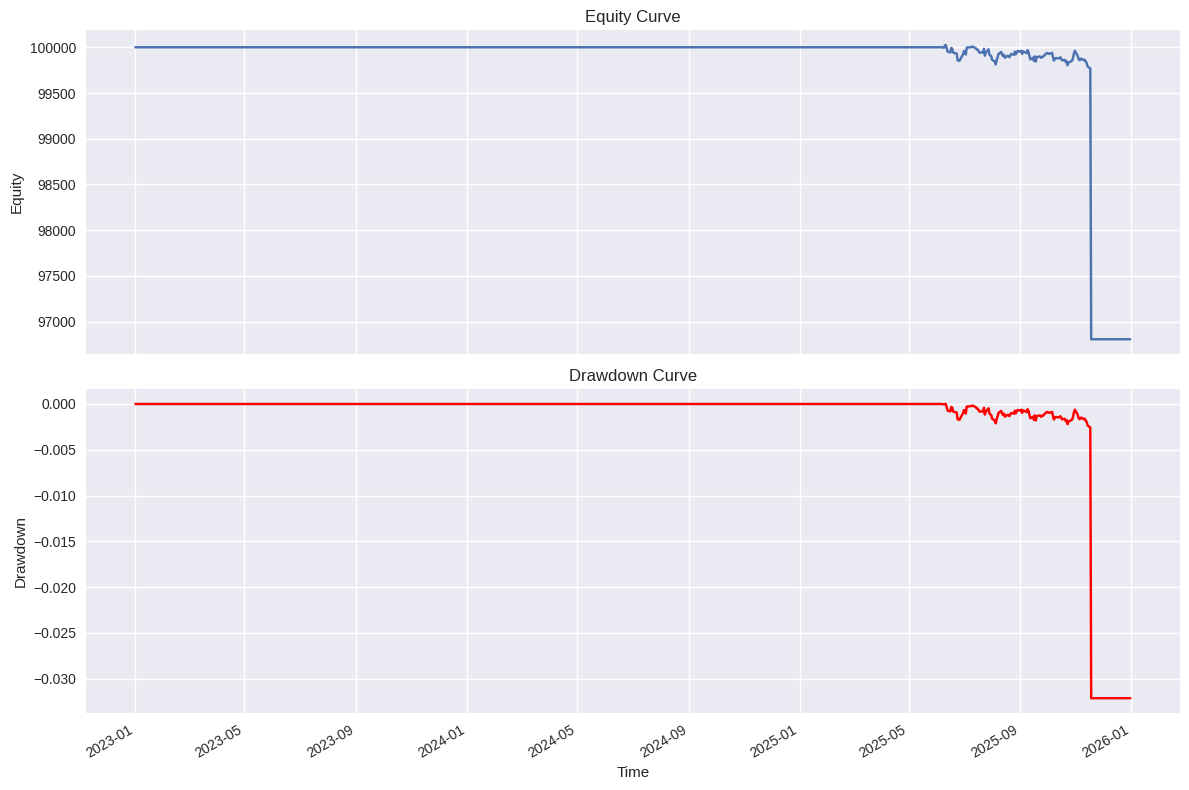

Number of trades: 1
Sample of trades:


,side,entry_price,exit_price,qty,pnl
0,LONG,126.94208,115.476593,23,-267.690147


In [44]:
# ========================
# Safe plot cell that runs backtest if needed and then plots results
# ========================

import traceback

# Helper to check existence of a name in globals
def exists(name):
    return name in globals() and globals()[name] is not None

# Verify minimal environment (classes and data must exist)
required_names = [
    "MovingAverageCrossoverStrategy",
    "RiskManager",
    "Backtester",
    "strategy_cfg",
    "risk_cfg",
    "bt_cfg",
    "data",
    "compute_drawdown",
]

missing = [n for n in required_names if n not in globals()]
if missing:
    raise RuntimeError(f"Missing required objects. Please run the earlier cells that define: {', '.join(missing)}")

# If equity/trades are missing or empty, attempt to run the backtest now
if (not exists("equity")) or (not isinstance(globals().get("equity", None), (pd.Series,)) ) or (len(globals().get("equity", [])) == 0) \
   or (not exists("trades")):
    print("equity/trades not found or empty — running backtest now to generate them...")
    try:
        # instantiate strategy, risk manager, and backtester using current configs
        strategy = MovingAverageCrossoverStrategy(
            short_window = strategy_cfg.short_ma,
            long_window  = strategy_cfg.long_ma
        )
        rm = RiskManager(risk_cfg)
        bt = Backtester(
            data = data,
            strategy = strategy,
            risk_manager = rm,
            bt_config = bt_cfg,
            ticker = "SYNTH_NSE"
        )
        equity, trades = bt.run()
        report = bt.performance_report(equity, trades)
        print("Backtest completed. Summary:")
        for k, v in report.items():
            print(f"{k:25s}: {v}")
    except Exception as e:
        print("Backtest failed with an exception. See traceback below.")
        traceback.print_exc()
        raise RuntimeError("Backtest failed — fix the underlying error before plotting.") from e
else:
    print("Found existing equity and trades variables. Proceeding to plot.")

# Final checks before plotting
if not isinstance(equity, pd.Series) or len(equity) == 0:
    raise RuntimeError("equity is not a non-empty pandas Series. Cannot plot.")

# Plot equity and drawdown
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Equity curve
try:
    equity.plot(ax=axes[0])
except Exception:
    # fallback to plotting values only
    axes[0].plot(range(len(equity)), equity.values)
axes[0].set_ylabel("Equity")
axes[0].set_title("Equity Curve")
axes[0].grid(True)

# Drawdown curve
dd = compute_drawdown(equity)
try:
    dd.plot(ax=axes[1], color="red")
except Exception:
    axes[1].plot(range(len(dd)), dd.values, color="red")
axes[1].set_ylabel("Drawdown")
axes[1].set_xlabel("Time")
axes[1].set_title("Drawdown Curve")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Display trades
print("Number of trades:", len(trades) if 'trades' in globals() else 0)
if 'trades' in globals() and isinstance(trades, (pd.DataFrame,)) and not trades.empty:
    print("Sample of trades:")
    display(trades.head())
else:
    print("No trades executed or trades is empty.")


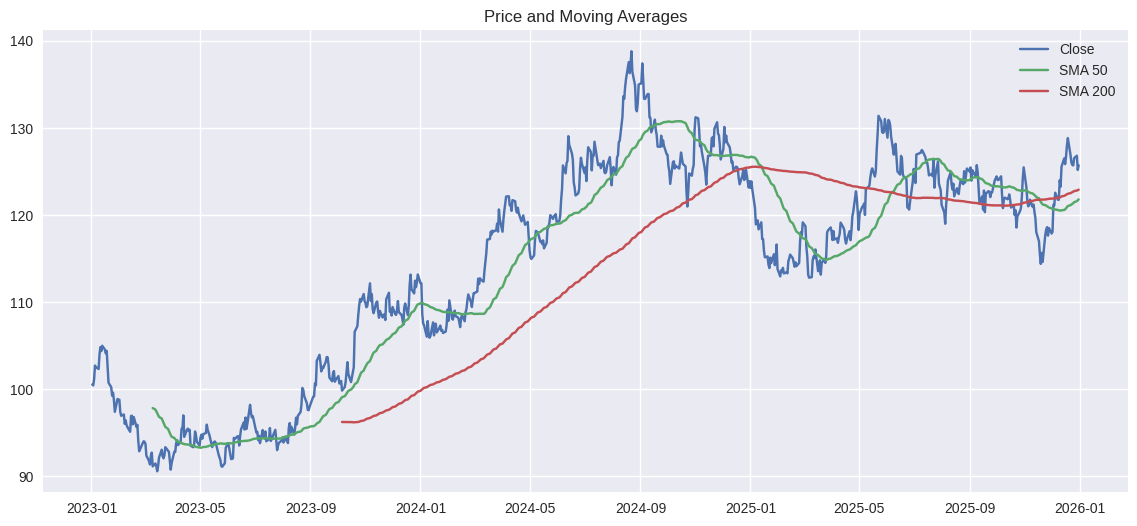

In [45]:
# Price chart with 50/200 MAs and signal markers
df_signals = strategy.generate_signals(data.reset_index().rename(columns={'timestamp':'index'}).set_index('index'))
plt.figure(figsize=(14,6))
plt.plot(df_signals.index, df_signals['close'], label='Close')
plt.plot(df_signals.index, df_signals['sma_short'], label=f'SMA {strategy_cfg.short_ma}')
plt.plot(df_signals.index, df_signals['sma_long'], label=f'SMA {strategy_cfg.long_ma}')
plt.legend()
plt.title('Price and Moving Averages')
plt.show()

In [46]:
# Export trades to CSV
if not trades.empty:
    trades.to_csv('trades_sample.csv', index=False)
    print('Trades exported to trades_sample.csv')
else:
    print('No trades to export.')

Trades exported to trades_sample.csv


Next steps

We can extend this notebook to integrate real broker APIs (Zerodha, Upstox, Angel One) for live or paper trading.
We can also refine the strategy, tune risk parameters, add portfolio allocation logic, or plug in real historical data.
